In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import flt

In [2]:
def cl2xi(cl: np.ndarray, closed = False):
    ls = np.arange(0, len(cl))
    factorcl = (2*ls+1)/(4*np.pi)
    coeffs = cl*factorcl
    return flt.idlt(coeffs, closed = closed)


def theta(n, closed = False):
    '''
    Returns the theta for which the cl2xi are calculated, for a given n
    '''
    return flt.theta(n, closed = closed)


def xi2cl(xi: np.ndarray, closed = False):
    ls = np.arange(0, len(xi))
    factorcl = (2*ls+1)/(4*np.pi)
    return flt.dlt(xi, closed = closed)/factorcl

In [3]:
def get_mean_from_map(mappa: np.ndarray):
    return np.mean(mappa)

def get_variance_from_map(mappa: np.ndarray):
    return np.mean(mappa**2.)-np.mean(mappa)**2.

def get_skew_from_map(mappa: np.ndarray):
    return np.mean((mappa-get_mean_from_map(mappa))**3.)/np.mean(mappa**2.)**1.5

def y_skew(skew):
    '''
    Formula (12) from https://arxiv.org/pdf/1602.08503.pdf
    '''
    result = 2+skew**2.+skew*np.sqrt(4+skew**2.)
    result /= 2
    return np.power(result, 1/3.)

def get_lambda_from_skew(skew, var, mu):
    lmbda = np.sqrt(var)/skew*(1+y_skew(skew)+1/y_skew(skew))-mu
    return lmbda 

def get_alpha(mu, lmbda):
    '''
    Below formula (7) from https://arxiv.org/pdf/1602.08503.pdf
    '''
    return mu+lmbda

def get_mu_gauss(alpha, var):
    '''
    Gets the mu parameter for the Gaussian distribution for the log-normal
    '''
    result = np.log(alpha**2./np.sqrt(var+alpha**2.))
    return result

def get_sigma_gauss(alpha, var):
    '''
    Gets the sigma parameter for the Gaussian distribution for the log-normal.

    Here the variance is the variance of the wanted log-normal field.
    '''
    result = np.log(1+var/alpha**2.)
    result = np.sqrt(result)
    return result

In [99]:
suppress = lambda l, lsup, supindex: np.exp(-1.0*np.power(l/lsup, supindex))

def process_cl(inputcl: np.ndarray, lsup: float = 7000, supindex: float = 10):
    ls = np.arange(0, len(inputcl))
    result = inputcl*suppress(ls, lsup, supindex)
    return result
    
def get_alpha(mu, lmbda):
    '''
    Below formula (7) from https://arxiv.org/pdf/1602.08503.pdf
    '''
    return mu+lmbda



def create_lognormal_single_map(inputcl: np.ndarray, nside: int, lmax_gen: int, mu: float = 0.0, lamb: float = 0.0):
    alpha = get_alpha(mu, lamb)
    xisinput = cl2xi(inputcl)/alpha/alpha

    xigaussian = np.log(xisinput+1)
    clgaussian = xi2cl(xigaussian)

    vargauss = np.dot(np.arange(1, 2*len(clgaussian), 2), clgaussian)/(4*np.pi)

    lmax_gen = 2*nside-1 if lmax_gen is None else lmax_gen
    almgaussian = hp.synalm(clgaussian, lmax = lmax_gen) #GENERATE TO HIGH LMAX
    maps = hp.alm2map(almgaussian, nside = nside, pol = False)
    
    #vargauss = np.array([xigaussian[i, i][0] for i in range(Nfields)])
    #vargauss = np.array([np.var(m) for m in maps])

    expmu = (mu+lamb)*np.exp(-vargauss*0.5)
    maps = np.array(maps)
    maps = np.exp(maps) 
    maps *= expmu
    maps -= lamb
    return maps


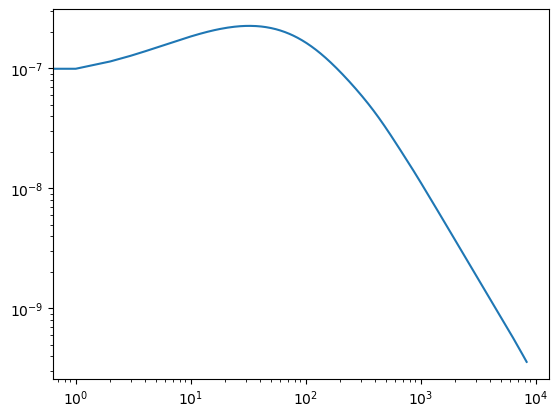

In [5]:
inputs_data_camb = np.loadtxt("../input/giulio/lensedCMB_dmn1_lenspotentialCls.dat")
lscamb = inputs_data_camb[:, 0]
kk = inputs_data_camb[:, 5]
kk *= np.pi/2
plt.loglog(kk)

Text(0, 0.5, '$C_{\\ell}$')

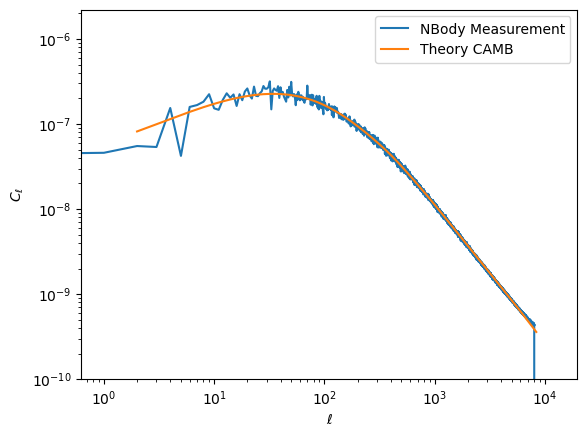

In [6]:
input_data = np.loadtxt("kappa_first.txt")
ls = np.arange(0, len(input_data))
plt.loglog(ls, input_data, label = 'NBody Measurement')
plt.loglog(lscamb, kk, label = 'Theory CAMB')
plt.ylim(1e-10)
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')

In [74]:
input_spectrum = input_data #process_cl(input_data)

Text(0, 0.5, '$C_{\\ell}$')

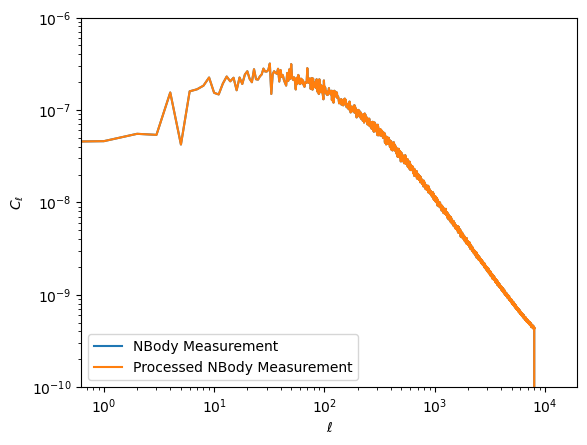

In [75]:
plt.loglog(ls, input_data, label = 'NBody Measurement')
plt.loglog(ls, input_spectrum, label = 'Processed NBody Measurement')
plt.ylim(1e-10, 1e-6)
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')

In [76]:
input_map = "/Users/omard/Downloads/SCRATCHFOLDER/giuliosims/map0_kappa_ecp262_dmn2_lmax8000_first.fits"
mappa = hp.read_map(input_map)
#hp.mollview(mappa, title = 'Input Map')

In [110]:
skewness = get_skew_from_map(mappa)
variance = get_variance_from_map(mappa)
mean = get_mean_from_map(mappa)
lamb = get_lambda_from_skew(skewness, variance, mean)

alpha = get_alpha(mean, lamb)
sigmaG = get_sigma_gauss(alpha, variance)
muG = get_mu_gauss(alpha, variance)

In [135]:
#shifted log-normal distribution
def shifted_lognormal_zero_mean(x, sigmaG, lamb):
    #equation (22) of https://www.aanda.org/articles/aa/pdf/2011/12/aa17294-11.pdf
    return np.exp(-(np.log(x/lamb+1)+sigmaG**2/2)**2./(2.*sigmaG**2.))/(x+lamb)/sigmaG/np.sqrt(2.*np.pi)*(x>-lamb)

def get_out_quantities(outmap: np.ndarray):
    skewness = get_skew_from_map(outmap)
    variance = get_variance_from_map(outmap)
    mean = get_mean_from_map(outmap)
    lamb = get_lambda_from_skew(skewness, variance, mean)

    alpha = get_alpha(mean, lamb)
    sigmaG = get_sigma_gauss(alpha, variance)
    muG = get_mu_gauss(alpha, variance)
    return mean, variance, skewness, lamb, muG, sigmaG

In [136]:
nside = 4096
lmax_gen = 8000

In [128]:
#lamb = 1

In [130]:
outmap = create_lognormal_single_map(inputcl = input_spectrum, nside = nside, lmax_gen = lmax_gen, mu = mean, lamb = lamb)

### Check spectrum of outmap vs input spectrum vs Gaussian realization

In [131]:
outmap_alm = hp.map2alm(outmap)
outmap_cl = hp.alm2cl(outmap_alm)

In [132]:
gaussian_alm = hp.synalm(input_spectrum, lmax = 3*nside-1, new = True)
gaussian_map = hp.alm2map(gaussian_alm, nside = nside, pixwin = False, pol = False, lmax = lmax_saving)
gaussian_cl = hp.alm2cl(gaussian_alm)

In [133]:
lsoutmap = np.arange(0, len(outmap_cl))
lsgaussian = np.arange(0, len(gaussian_cl))

Text(0, 0.5, '$C_{\\ell}$')

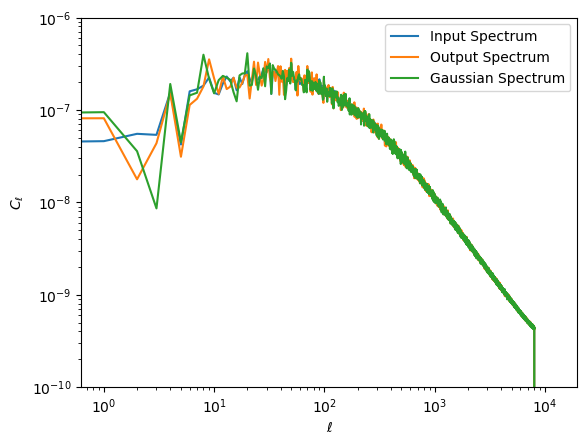

In [134]:
#plot quantities
plt.loglog(ls, input_spectrum, label = 'Input Spectrum')
plt.loglog(lsoutmap, outmap_cl, label = 'Output Spectrum')
plt.loglog(lsgaussian, gaussian_cl, label = 'Gaussian Spectrum')
plt.ylim(1e-10, 1e-6)
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')

### Check statistical properties

In [140]:
meano, varo, skewo, lambo, meanGo, sigmaGo = get_out_quantities(outmap)

Text(0, 0.5, '$P(\\kappa)$')

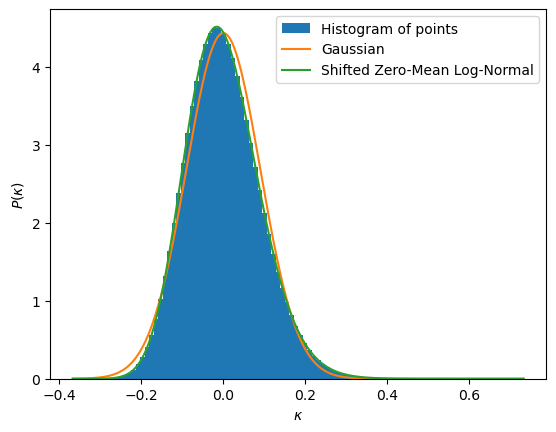

In [143]:
from scipy import stats
#create histogram of points of outmap and compare with gaussian
plt.hist(outmap, bins = 100, density = True, label = 'Histogram of points')
x = np.linspace(outmap.min(), outmap.max(), 1000)
plt.plot(x, stats.norm.pdf(x, meano, np.sqrt(varo)), label = 'Gaussian')
plt.plot(x, shifted_lognormal_zero_mean(x, sigmaGo, lambo), label = 'Shifted Zero-Mean Log-Normal')
plt.legend()
plt.xlabel(r'$\kappa$')
plt.ylabel(r'$P(\kappa)$')


## Skewness in function of FWHM